# Multiclass Random Forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

In [116]:
def evaluate(X, y, n_estimators = 70, criterion = 'gini'):
    forest = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion)
    forest.fit(X,y)
    scoring = ['f1_macro', 'precision_macro', 'recall_macro'] 
    scores = []
    cv = cross_validate(forest, X, y, cv=10, scoring=scoring)
    scores.append(cv['test_precision_macro'].mean())
    scores.append(cv['test_recall_macro'].mean())
    scores.append(cv['test_f1_macro'].mean())
    return scores

In [118]:
def grid_eval(X, y, params):
    
    grid = GridSearchCV(RandomForestClassifier(), params, cv=10, scoring='f1_macro')
    grid.fit(X, y)
    
    return pd.DataFrame(grid.cv_results_)

In [90]:
def grid_search(X, y, params):
    
    results = []
    for x, f in zip(X,['user','descriptive','intrinsic','extrinsic','NSFW_detection','all']):
        grid = GridSearchCV(RandomForestClassifier(), params, cv=10, scoring='f1_macro')
        grid.fit(x, y)
        d1 = {'features': f}
        d2 = dict(list(grid.cv_results_.items()) + list(d1.items()))
        results.append(d2)
        print(f + ' done')

    return results

In [182]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, filename):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    fig, ax = plt.subplots(1,1, figsize=(16,12))
    

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(sorted(grid_param_1), scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
    
    
    best_index = np.argmax(cv_results['mean_test_score'])
    best_param = cv_results.loc[best_index]['param_n_estimators']
    best_score = cv_results['mean_test_score'].max()
    min_score = cv_results['mean_test_score'].min()
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    #ax.plot([best_param, ] * 2, [min_score, best_score],
        #    linestyle='-.', color='black', marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    #ax.annotate("%0.3f" % best_score,
        #        (best_param+5, best_score + 0.00005), size=16)

    ax.set_title("Grid Search Scores", fontsize=24)
    ax.set_xlabel(name_param_1, fontsize=24)
    ax.set_ylabel('F1 Macro Score', fontsize=24)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    fig.savefig('data/full/'+ filename +'.png')

In [10]:
full = pd.read_csv('data/full/rf_preproc_train.csv')

In [37]:
X = full.drop(columns=["user_id", "target", 'profile_background_color', 'profile_link_color',
       'profile_sidebar_border_color', 'profile_sidebar_fill_color',
       'profile_text_color'])
y = full['target']

### User features

In [30]:
# only our user features
X_user = X[['default_profile', 'favourites_count', 'followers_count', 'friends_count', 'listed_count','profile_use_background_image',
       'statuses_count', 'url', 'description_len',
       'name_len', 'screen_name_len', 'age']]

In [45]:
user_score = evaluate(X_user, y)
print('Precision:')
print(user_score[0])
print('Recall:')
print(user_score[1])
print('F1:')
print(user_score[2])

Precision:
0.9017750468574546
Recall:
0.898622708146549
F1:
0.8945389280374563


### Descriptive features

In [29]:
# only our descriptive features
X_desc = X[['avg_fav', 'avg_hash', 'avg_len', 'avg_ret',
       'freq', 'max_fav', 'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_fav', 'min_hash',
       'min_len', 'min_ret', 'quote_perc',
       'ret_perc', 'url_perc']]

In [46]:
desc_score = evaluate(X_desc, y)
print('Precision:')
print(desc_score[0])
print('Recall:')
print(desc_score[1])
print('F1:')
print(desc_score[2])

Precision:
0.782224051547425
Recall:
0.7723707414788237
F1:
0.7556068965376048


### Intrinsic features

In [31]:
# only our intrinsic features
X_intr = X[['tweet_intradistance', 'url_intradistance']]

In [47]:
intr_score = evaluate(X_intr, y)
print('Precision:')
print(intr_score[0])
print('Recall:')
print(intr_score[1])
print('F1:')
print(intr_score[2])

Precision:
0.631609113227902
Recall:
0.635212342122743
F1:
0.6085732576560329


### Extrinsic features

In [32]:
# only our extrinsic features
X_extr = X[['porn_words_score', 'prop_words_score', 'spam_words_score', 'fake_words_score', 'genuine_words_score']]

In [48]:
extr_score = evaluate(X_extr, y)
print('Precision:')
print(extr_score[0])
print('Recall:')
print(extr_score[1])
print('F1:')
print(extr_score[2])

Precision:
0.7347553081435488
Recall:
0.726894984246718
F1:
0.7081390878628695


### NSFW features

In [33]:
# only our NSFW features
X_imgs = X[['nsfw_avg', 'nsfw_profile']]

In [49]:
imgs_score = evaluate(X_imgs, y)
print('Precision:')
print(imgs_score[0])
print('Recall:')
print(imgs_score[1])
print('F1:')
print(imgs_score[2])

Precision:
0.5564041703233775
Recall:
0.5444704280674533
F1:
0.5447488799562488


### All features

In [117]:
all_score = evaluate(X, y)
print('Precision:')
print(all_score[0])
print('Recall:')
print(all_score[1])
print('F1:')
print(all_score[2])

Precision:
0.9460909079907646
Recall:
0.9458356041006653
F1:
0.9431363912418529


## Performance comparison

In [110]:
X_list = [X_user, X_desc, X_intr, X_extr, X_imgs, X]
params = {'n_estimators':[10,20,30,40,50,60,70]}

In [111]:
results = grid_search(X_list, y, params)

user done
descriptive done
intrinsic done
extrinsic done
NSFW_detection done
all done


In [112]:
res = pd.DataFrame()
for elem in results:
    res=res.append(pd.DataFrame(elem), ignore_index=True)

In [113]:
n_estimators = [10,20,30,40,50,60,70]
features = ['user','descriptive','intrinsic','extrinsic','NSFW_detection','all']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


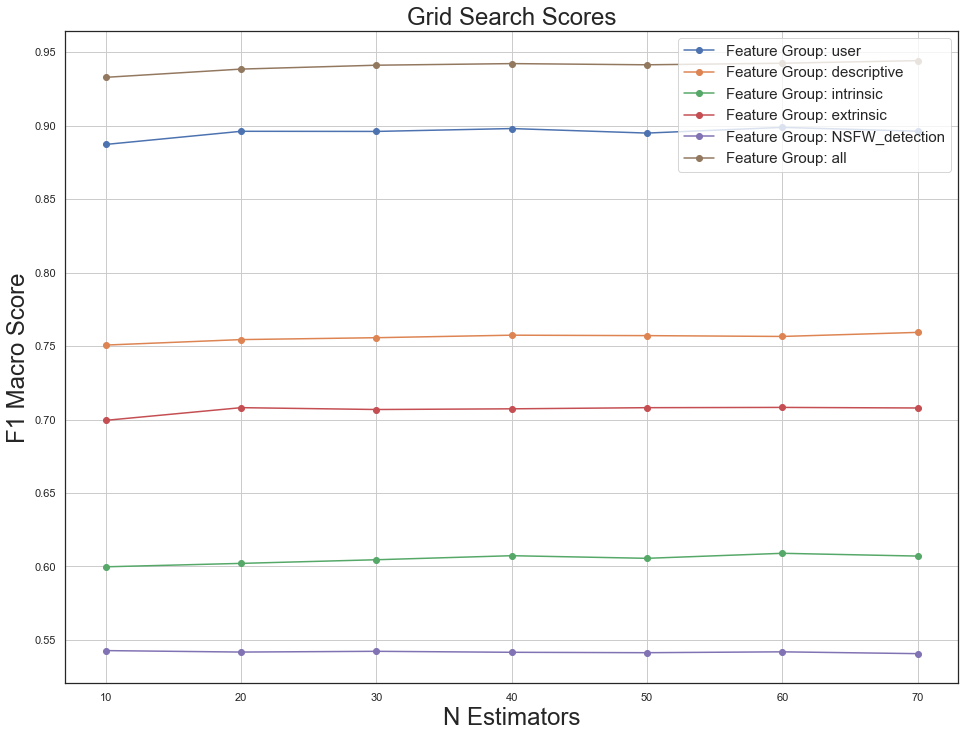

In [114]:
plot_grid_search(res, n_estimators, features, 'N Estimators', 'Feature Group')

In [170]:
params = {'n_estimators':[100,150,200,250,300], 'max_depth':[None,24,26,28], 'criterion':['gini','entropy']}

In [171]:
grid = grid_eval(X,y, params)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/

In [172]:
gini_grid = grid[grid['param_criterion'] == 'gini']

In [173]:
entropy_grid = grid[grid['param_criterion'] == 'entropy']

In [174]:
n_estimators = [100,150,200,250,300]
max_depth = [None,24,26,28]

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


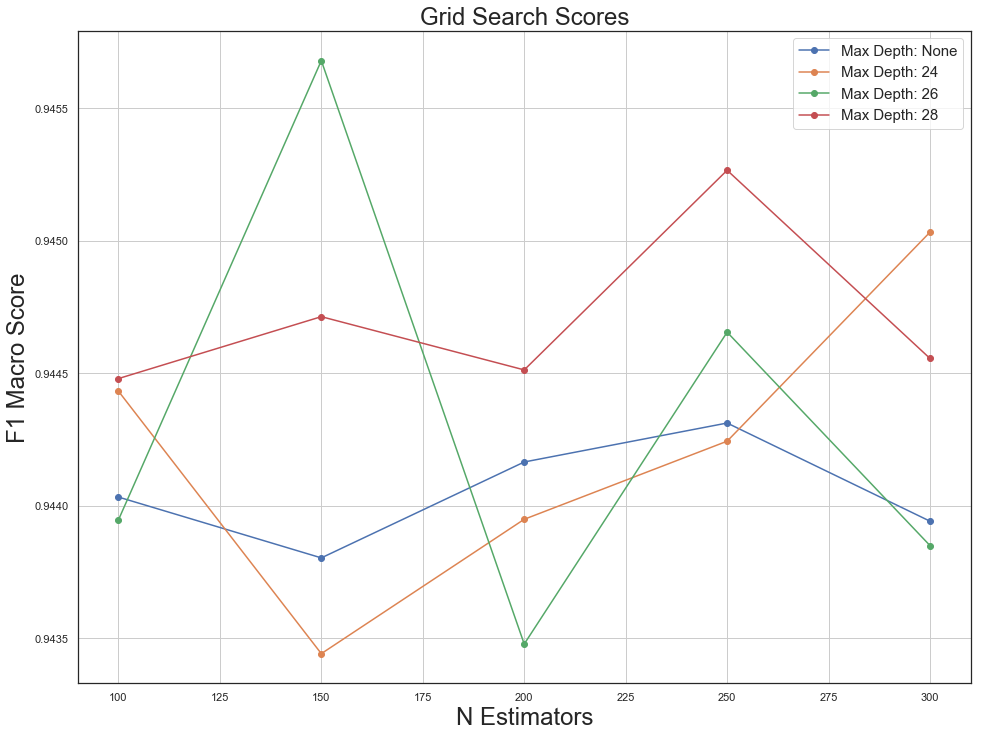

In [183]:
plot_grid_search(gini_grid, n_estimators, max_depth, 'N Estimators', 'Max Depth', 'gini')

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


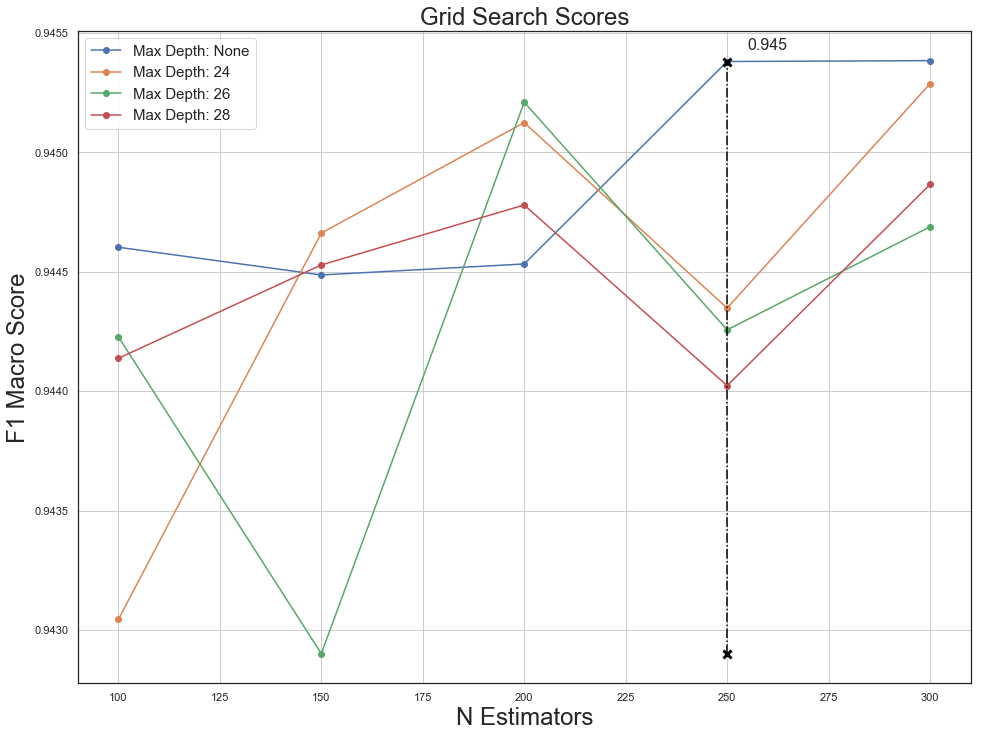

In [180]:
plot_grid_search(entropy_grid, n_estimators, max_depth, 'N Estimators', 'Max Depth', 'entropy')

In [184]:
model = RandomForestClassifier(n_estimators = 250, max_depth = None, criterion = 'entropy')

In [185]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [187]:
import time

In [188]:
start = time.time()
model.predict_proba(np.array(X.iloc[0]).reshape(1, -1))
end = time.time()
print("Prediction time: " + str(end - start))

Prediction time: 0.03341794013977051


In [189]:
pickle.dump(model, open("../scripts/rf.model", "wb"))